In [1]:
!pip install einops
%load_ext autoreload
%autoreload 2

import seaborn as sns
from dataclasses import dataclass
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


## Create Args Configuration Class

In [19]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 16
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 50
    window_size: int = 5

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [20]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.33,
        'global_vatiant_contrast': 0.33,
        'dynamic_trend_pred': 0.34,
    },
    eval=False,
    batch_size=32,
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)

## Load your HAR data
The UCIHAR dataset records 6 activities of daily living, i.e., walking, sitting, laying, standing, walking upstairs and walking downstairs. 30 participants at an age between 19 to 48 carry a smartphone on the waist while performing the activities. The smartphone records reading at a sampling rate of 50 Hz. The time-series measurements are pre-processed to extract 561 features.

Preprocess the HAR data to concatenate individual measurements. Shape of processed data: $(N, C, T)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.

In [21]:
# !python datasets/preprocess_HAR.py

In [22]:
train_data, train_labels, test_data, test_labels = datautils.load_HAR("HAR_data")
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(f"Shapes - train labels: {train_labels.shape}, test labels: {test_labels.shape}")

Shapes - train data: (21, 561, 281), test data: (9, 561, 288)
Shapes - train labels: (21, 281), test labels: (9, 288)


Reorder the dimension and form your data into an `np.ndarray` of shape $(N, T, C)$

In [23]:
train_data = np.transpose(train_data, (0, 2, 1)) 
test_data = np.transpose(test_data, (0, 2, 1))    
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(f"Shapes - train labels: {train_labels.shape}, test labels: {test_labels.shape}")

Shapes - train data: (21, 281, 561), test data: (9, 288, 561)
Shapes - train labels: (21, 281), test labels: (9, 288)


## Create and Train the model

In [24]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

3477

In [25]:
import time
start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_data,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (21, 281, 561)
Epoch #0: loss=1.2359646558761597
Epoch #1: loss=2.489485025405884
Epoch #2: loss=1.23723304271698
Epoch #3: loss=1.2339050769805908
Epoch #4: loss=1.2331393957138062
Epoch #5: loss=1.232339859008789
Epoch #6: loss=1.2309372425079346
Epoch #7: loss=1.2308143377304077
Epoch #8: loss=1.2340971231460571
Epoch #9: loss=1.2302314043045044
Epoch #10: loss=1.2297133207321167
Epoch #11: loss=1.2291878461837769
Epoch #12: loss=1.230139970779419
Epoch #13: loss=1.2288668155670166
Epoch #14: loss=1.2255644798278809
Epoch #15: loss=1.2245978116989136
Epoch #16: loss=1.2238385677337646
Epoch #17: loss=1.2243462800979614
Epoch #18: loss=1.226793646812439
Epoch #19: loss=1.2244796752929688
Epoch #20: loss=1.2209945917129517
Epoch #21: loss=1.2265053987503052
Epoch #22: loss=1.2216588258743286
Epoch #23: loss=1.2188867330551147
Epoch #24: loss=1.2180241346359253
Epoch #25: loss=1.2122465372085571
Epoch #26: loss=1.213141918182373
Epoch #27: loss=1.2216815948486328
E

Save model and loss log

In [26]:
import torch
torch.save(model, 'logs/mymodel_HAR.pth')
import pandas as pd
df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
df.to_csv("logs/loss_log_HAR.csv", index=False)

Visualize the loss curve and save figure

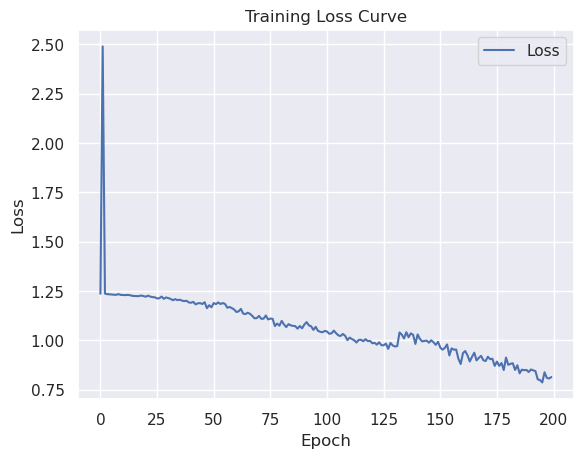

In [27]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a simple classifier (svm) using training representation and corresponding training labels. Finally, use the classifier to do calssification for test representation. Report the acc and auprc.

Best_acc: 0.9072764227642276 Best_auc: 0.9889490338602046 Best_aupc: 0.9521361164145543
=======> Performance Summary:


TypeError: not all arguments converted during string formatting

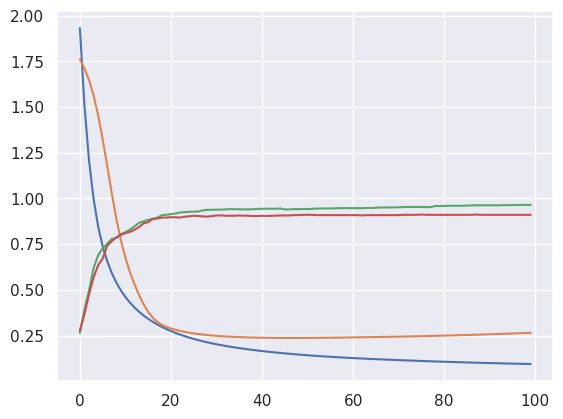

In [38]:
from tasks.state_prediction import eval_state_prediction
eval_state_prediction(model,train_data,train_labels,test_data,test_labels,lr=0.001)